# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Пропусков в данных не обноружено

In [3]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


Разделим на features (X) and target (y)

In [4]:
X = df.drop(columns=['is_ultra'])
y = df['is_ultra']

Соотношение классов

In [5]:
y.value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

In [6]:
y.value_counts() / y.shape[0] * 100

0    69.352831
1    30.647169
Name: is_ultra, dtype: float64

Посмотрим на гистограмы распеределения данных

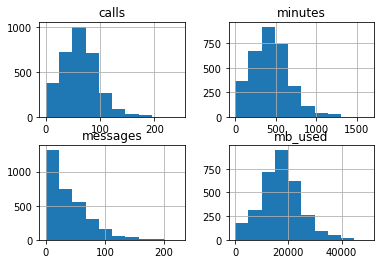

In [7]:
X.hist()
None

1) **calls** Имеет нормальное распределение данных со смещением в лево

2) **minutes** Имеет нормальное распределение данных со смещением в лево

3) **messages** Имеет пауссоновское распределение данных

4) **mb_used** Имеет нормальное распределение данных

Задача - бинарная классификация, обучение с учителем, так же хочу заметить что классы не сбалансированы

**Кореляция признаков**

In [8]:
import seaborn as sns

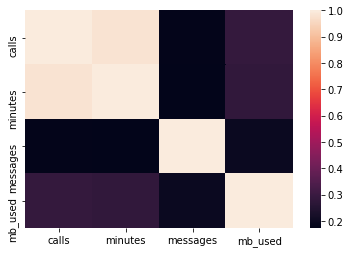

In [9]:
sns.heatmap(X.corr())
None

Заметим, что количество звонков коррелирует с количеством минут, оставим только признак "количество минут" и удалим признак "количество звонков"

In [10]:
X = X.drop(columns=['calls'])

## Разбейте данные на выборки

Будем следовать соотношению
* train 60%
* valid 20%
* test 20%

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=42)

## Исследуйте модели

Решение задачи бинарной классификации будет выполняться следующими алгоритмами:
1) Логистической регрессии

2) Метод ближайших соседей

3) Решающий лес

4) Опорные вектора

5) Градиентный бустинг (Catboost)

6) Ансамблирование

7) Наивный байесовский классификатор

8) Линейный дискриминантный анализ

9) Multi-layer Perceptron (MLP)

Качество модели будем определять по accuracy (как требуют в задании).
Учитывая что классы в задании не сбалансированы
* 0 (70%)
* 1 (30%)
Если везде ставить 0 то accuracy будет 0.7

Поэтому я буду так же оценивать полноту, точность и f1 меру

In [13]:
from sklearn.metrics import classification_report

In [14]:
def get_report_of_model(_title, _model, _X_train, _y_train, _X_test, _y_test) -> None:
    '''
    1) Обучаем полученную модель
    2) Делаем предсказание
    3) Считаем метрики
    '''
    _model.fit(_X_train, _y_train)
    _y_pred = _model.predict(_X_test)
    report = classification_report(_y_test, _y_pred)
    print(_title)
    print(report)

Список результатов моделей

In [15]:
results = []

### 1 Логистическая регрессия

In [16]:
from sklearn.linear_model import LogisticRegression

In [1]:
log_reg = LogisticRegression(random_state=42)
get_report_of_model('Логистическая регрессия, ненормализованные данные', log_reg, X_train, y_train, X_valid, y_valid)

NameError: name 'LogisticRegression' is not defined

Нормализуем данные

from sklearn.preprocessing import Normalizer

transformer = Normalizer().fit(X_train)
X_train_normalize = transformer.transform(X_train)

transformer = Normalizer().fit(X_valid)
X_valid_normalize = transformer.transform(X_valid)

log_reg = LogisticRegression(random_state=42)
get_report_of_model('Логистическая регрессия, нормализованные данные',
                    log_reg, X_train_normalize, y_train, X_valid_normalize, y_valid)

Нормализованные данные не показали улучшений метрик

In [18]:
results.append({
    'Название модели': 'Логистическая регрессия',
    'precision': (0.74 + 0.80) / 2,
    'recal': (0.97 + 0.22) / 2,
    'f1-score': (0.84 + 0.35) / 2,
    'accuracy': 0.75
})

### 2 Метод ближайших соседей

In [19]:
from sklearn.cluster import KMeans

In [20]:
km = KMeans(n_clusters=2, random_state=42)
get_report_of_model('Метод ближайших соседей, ненормализованные данные', km, X_train, y_train, X_valid, y_valid)

Метод ближайших соседей, ненормализованные данные
              precision    recall  f1-score   support

           0       0.76      0.60      0.67       358
           1       0.39      0.57      0.46       157

    accuracy                           0.59       515
   macro avg       0.58      0.59      0.57       515
weighted avg       0.65      0.59      0.61       515



Результат хуже, чем у логистической регрессии

In [21]:
results.append({
    'Название модели': 'Метод ближайших соседей',
    'precision': (0.76 + 0.39) / 2,
    'recal': (0.60 + 0.57) / 2,
    'f1-score': (0.67 + 0.46) / 2,
    'accuracy': 0.59
})

### 3 Деревья

Подбор гипер параметров, таких как
1) Максимальная глубина

2) Минимальное количество образцов необходимое для разделения

3) Минимальное количество образцов, необходимое для нахождения в листовом узле

4) Количество деревьев

In [22]:
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score
import seaborn as sns

In [23]:
def plot_fitting_curve(_model, _parameter: str, _values: list, _X_train, _X_valid, _y_train, _y_valid):
    train_curve, valid_curve = [], []
    for value in tqdm(_values):
        model = _model(**{_parameter: value})
        model.fit(_X_train, _y_train)
        y_pred_train, y_pred_test = model.predict(_X_train), model.predict(_X_valid)
        train_curve.append(f1_score(_y_train, y_pred_train, average='weighted'))
        valid_curve.append(f1_score(_y_valid, y_pred_test, average='weighted'))
    sns.lineplot(x=_values, y=train_curve, label="Train").set_title(_parameter)
    sns.lineplot(x=_values, y=valid_curve, label="Valid")

#### 3.1 Решающее дерево

In [24]:
from sklearn.tree import DecisionTreeClassifier

##### 3.1.1 Максимальная глубина

  0%|          | 0/9 [00:00<?, ?it/s]

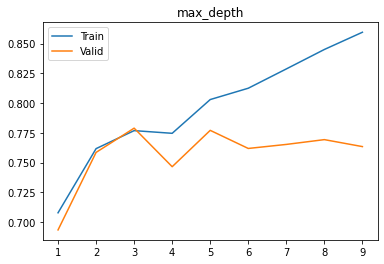

In [25]:
plot_fitting_curve(
    _model=DecisionTreeClassifier,
    _parameter='max_depth',
    _values=list(range(1, 10)),
    _X_train=X_train,
    _X_valid=X_valid,
    _y_train=y_train,
    _y_valid=y_valid
)

Максимальная глубина дерева 3

##### 3.1.2 Минимальное количество образцов необходимое для разделения

  0%|          | 0/398 [00:00<?, ?it/s]

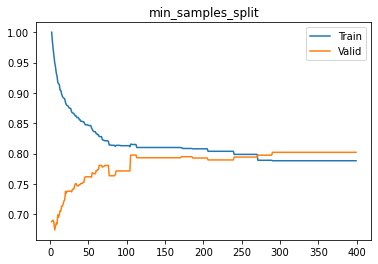

In [26]:
plot_fitting_curve(
    _model=DecisionTreeClassifier,
    _parameter='min_samples_split',
    _values=list(range(2, 400)),
    _X_train=X_train,
    _X_valid=X_valid,
    _y_train=y_train,
    _y_valid=y_valid
)

Минимальное количество образцов необходимое для разделения = 110

##### 3.1.3 Минимальное количество образцов, необходимое для нахождения в листовом узле

  0%|          | 0/69 [00:00<?, ?it/s]

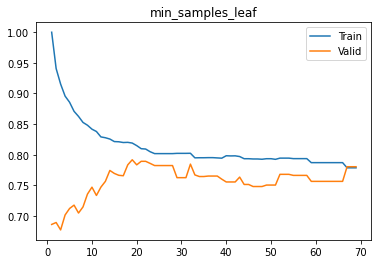

In [27]:
plot_fitting_curve(
    _model=DecisionTreeClassifier,
    _parameter='min_samples_leaf',
    _values=list(range(1, 70)),
    _X_train=X_train,
    _X_valid=X_valid,
    _y_train=y_train,
    _y_valid=y_valid
)

Минимальное количество образцов, необходимое для нахождения в листовом узле = 20

In [28]:
dtc = DecisionTreeClassifier(max_depth=3, min_samples_split=110, min_samples_leaf=20, random_state=42)
get_report_of_model('Решающее дерево', dtc, X_train, y_train, X_valid, y_valid)

Решающее дерево
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       358
           1       0.75      0.51      0.61       157

    accuracy                           0.80       515
   macro avg       0.78      0.72      0.74       515
weighted avg       0.79      0.80      0.79       515



На данный момент самый лучший результат

In [29]:
results.append({
    'Название модели': 'Решающее дерево',
    'precision': (0.81 + 0.75) / 2,
    'recal': (0.92 + 0.51) / 2,
    'f1-score': (0.86 + 0.61) / 2,
    'accuracy': 0.80
})

#### 3.2 Решающий лес

In [30]:
from sklearn.ensemble import RandomForestClassifier

##### 3.2.1 Максимальная глубина

  0%|          | 0/19 [00:00<?, ?it/s]

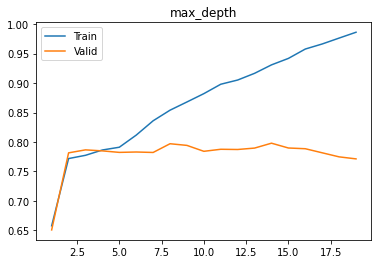

In [31]:
plot_fitting_curve(
    _model=RandomForestClassifier,
    _parameter='max_depth',
    _values=list(range(1, 20)),
    _X_train=X_train,
    _X_valid=X_valid,
    _y_train=y_train,
    _y_valid=y_valid
)

Максимальная глубина = 5

##### 3.2.2 Минимальное количество образцов необходимое для разделения

  0%|          | 0/98 [00:00<?, ?it/s]

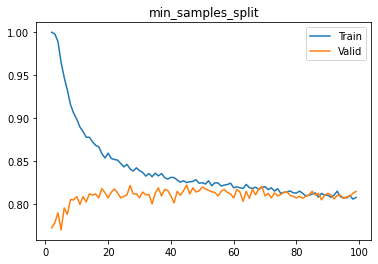

In [32]:
plot_fitting_curve(
    _model=RandomForestClassifier,
    _parameter='min_samples_split',
    _values=list(range(2, 100)),
    _X_train=X_train,
    _X_valid=X_valid,
    _y_train=y_train,
    _y_valid=y_valid
)

Минимальное количество образцов необходимое для разделения = 90

##### 3.2.3 Минимальное количество образцов, необходимое для нахождения в листовом узле

  0%|          | 0/19 [00:00<?, ?it/s]

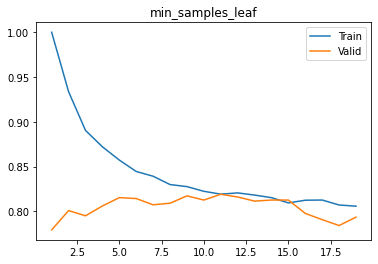

In [33]:
plot_fitting_curve(
    _model=RandomForestClassifier,
    _parameter='min_samples_leaf',
    _values=list(range(1, 20)),
    _X_train=X_train,
    _X_valid=X_valid,
    _y_train=y_train,
    _y_valid=y_valid
)

Минимальное количество образцов, необходимое для нахождения в листовом узле = 13

##### 3.2.4 Количество деревьев

  0%|          | 0/19 [00:00<?, ?it/s]

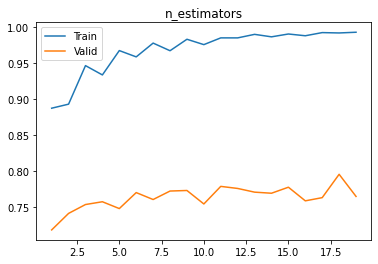

In [34]:
plot_fitting_curve(
    _model=RandomForestClassifier,
    _parameter='n_estimators',
    _values=list(range(1, 20)),
    _X_train=X_train,
    _X_valid=X_valid,
    _y_train=y_train,
    _y_valid=y_valid
)

Количество деревьев = 8

In [35]:
dfc = RandomForestClassifier(max_depth=5, min_samples_split=90, min_samples_leaf=13, random_state=42, n_estimators=8)
get_report_of_model('Решающие деревья', dfc, X_train, y_train, X_valid, y_valid)

Решающие деревья
              precision    recall  f1-score   support

           0       0.79      0.96      0.87       358
           1       0.81      0.42      0.55       157

    accuracy                           0.79       515
   macro avg       0.80      0.69      0.71       515
weighted avg       0.80      0.79      0.77       515



Наилучшие результаты на данный момент (немного лучше чем у решающего дерева)

In [36]:
results.append({
    'Название модели': 'Решающие деревья',
    'precision': (0.79 + 0.81) / 2,
    'recal': (0.96 + 0.42) / 2,
    'f1-score': (0.87 + 0.55) / 2,
    'accuracy': 0.79
})

### 3.3 Автоматический подбор гипер параметров c помощью optuna

In [37]:
!pip install optuna
import optuna

     |████████████████████████████████| 365 kB 1.2 MB/s eta 0:00:01


<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b>

Булат, с этой библиотекой я не знаком .... Судя по коду она помогает подбирать гиперпараметры. Но автоматизированный перебор по сетке на мой взгляд не хуже. Хотя повторюсь - с optuna я не сталкивался, возможно у неё ещё какие-то есть мощные бонусы для использования.
</div>

In [38]:
param_distributions = {
    "max_depth": optuna.distributions.IntDistribution(1, 30, step=1, log=False),
    'min_samples_split': optuna.distributions.IntDistribution(2, 100, step=1, log=False),
    'min_samples_leaf': optuna.distributions.IntDistribution(1, 100, step=1, log=False),
    'n_estimators': optuna.distributions.IntDistribution(1, 20, step=1, log=False)
}
optuna_search = optuna.integration.OptunaSearchCV(RandomForestClassifier(), param_distributions)
get_report_of_model('optuna Решающие деревья', optuna_search, X_train, y_train, X_valid, y_valid)

/tmp/ipykernel_115/2429947983.py:7: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = optuna.integration.OptunaSearchCV(RandomForestClassifier(), param_distributions)
[I 2023-03-09 12:50:30,377] A new study created in memory with name: no-name-494af93b-4c0e-486e-ac92-5d877ad29501
[I 2023-03-09 12:50:30,469] Trial 0 finished with value: 0.783579004559091 and parameters: {'max_depth': 4, 'min_samples_split': 58, 'min_samples_leaf': 14, 'n_estimators': 4}. Best is trial 0 with value: 0.783579004559091.
[I 2023-03-09 12:50:30,620] Trial 1 finished with value: 0.7680131339616848 and parameters: {'max_depth': 29, 'min_samples_split': 95, 'min_samples_leaf': 86, 'n_estimators': 9}. Best is trial 0 with value: 0.783579004559091.
[I 2023-03-09 12:50:30,795] Trial 2 finished with value: 0.7757990220395437 and parameters: {'max_depth': 4, 'min_samples_split': 87, 'min_samples_leaf': 96, 'n_estimators': 15}. Best

optuna Решающие деревья
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       358
           1       0.76      0.56      0.64       157

    accuracy                           0.81       515
   macro avg       0.79      0.74      0.76       515
weighted avg       0.81      0.81      0.80       515



Результаты после применения optuna оказались примерно одинаковыми, что и после ручного поиска гиперпараметров

In [39]:
results.append({
    'Название модели': 'optuna Решающие деревья',
    'precision': (0.83 + 0.76) / 2,
    'recal': (0.92 + 0.55) / 2,
    'f1-score': (0.87 + 0.64) / 2,
    'accuracy': 0.81
})

### 4 Опорные вектора

In [40]:
from sklearn import svm

In [41]:
svc = svm.SVC()
get_report_of_model('Метод опорных векторов', svc, X_train, y_train, X_valid, y_valid)

Метод опорных векторов
              precision    recall  f1-score   support

           0       0.74      0.98      0.84       358
           1       0.81      0.22      0.35       157

    accuracy                           0.75       515
   macro avg       0.78      0.60      0.60       515
weighted avg       0.76      0.75      0.69       515



In [42]:
results.append({
    'Название модели': 'Метод опорных векторов',
    'precision': (0.74 + 0.81) / 2,
    'recal': (0.98 + 0.22) / 2,
    'f1-score': (0.84 + 0.35) / 2,
    'accuracy': 0.75
})

### 5 Градиентный бустинг (Catboost)

In [43]:
# !pip install catboost
from catboost import CatBoostClassifier

In [44]:
catboosting = CatBoostClassifier(metric_period=300)
get_report_of_model('Catboost', catboosting, X_train, y_train, X_valid, y_valid)

Learning rate set to 0.014015
0:	learn: 0.6866991	total: 48.2ms	remaining: 48.1s
300:	learn: 0.4136882	total: 419ms	remaining: 972ms
600:	learn: 0.3765618	total: 761ms	remaining: 505ms
900:	learn: 0.3378480	total: 1.1s	remaining: 121ms
999:	learn: 0.3262513	total: 1.23s	remaining: 0us
Catboost
              precision    recall  f1-score   support

           0       0.83      0.92      0.88       358
           1       0.77      0.58      0.66       157

    accuracy                           0.82       515
   macro avg       0.80      0.75      0.77       515
weighted avg       0.81      0.82      0.81       515



Результаты оказались на таком же уровне, как optuna и ансамбль деревьев

In [45]:
results.append({
    'Название модели': 'Catboost',
    'precision': (0.83 + 0.77) / 2,
    'recal': (0.92 + 0.58) / 2,
    'f1-score': (0.88 + 0.66) / 2,
    'accuracy': 0.82
})

### 6 Ансамблирование

#### 6.1 Стекинг

Стекинг Лучших моделей (оформлял уже зная результаты ниже написанных алгоритмов)

In [46]:
from sklearn.ensemble import StackingClassifier
from sklearn.naive_bayes import GaussianNB

In [47]:
estimators = [
    ('catboosting', catboosting),
    ('optuna_search', optuna_search),
    ('dfc', dfc),
    ('GaussianNB', GaussianNB())
]
modelClf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), n_jobs=-1)
get_report_of_model('StackingClassifier', modelClf, X_train, y_train, X_valid, y_valid)

Learning rate set to 0.014015
0:	learn: 0.6866991	total: 1.5ms	remaining: 1.5s
300:	learn: 0.4136882	total: 353ms	remaining: 820ms
600:	learn: 0.3765618	total: 720ms	remaining: 478ms
900:	learn: 0.3378480	total: 1.09s	remaining: 120ms
999:	learn: 0.3262513	total: 1.22s	remaining: 0us


/opt/conda/lib/python3.9/site-packages/sklearn/base.py:77: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  new_object = klass(**new_object_params)
[I 2023-03-09 12:50:36,580] A new study created in memory with name: no-name-66771107-cfd4-4741-a949-53f358dde8a4
[I 2023-03-09 12:50:36,616] Trial 0 finished with value: 0.7582854983110103 and parameters: {'max_depth': 19, 'min_samples_split': 95, 'min_samples_leaf': 54, 'n_estimators': 1}. Best is trial 0 with value: 0.7582854983110103.
[I 2023-03-09 12:50:36,652] Trial 1 finished with value: 0.759251647650769 and parameters: {'max_depth': 15, 'min_samples_split': 76, 'min_samples_leaf': 61, 'n_estimators': 1}. Best is trial 1 with value: 0.759251647650769.
[I 2023-03-09 12:50:36,709] Trial 2 finished with value: 0.7869888739281412 and parameters: {'max_depth': 22, 'min_samples_split': 60, 'min_samples_leaf': 32, 'n_estimators': 3}. Best is trial 2 with value: 0.786988

Learning rate set to 0.012739
0:	learn: 0.6866742	total: 1.27ms	remaining: 1.27s
300:	learn: 0.3986131	total: 347ms	remaining: 806ms
600:	learn: 0.3612020	total: 676ms	remaining: 449ms
900:	learn: 0.3234510	total: 1.04s	remaining: 115ms
999:	learn: 0.3114247	total: 1.17s	remaining: 0us
Learning rate set to 0.012742
0:	learn: 0.6873573	total: 1.6ms	remaining: 1.6s
300:	learn: 0.4206334	total: 339ms	remaining: 787ms
600:	learn: 0.3793381	total: 685ms	remaining: 455ms
900:	learn: 0.3383217	total: 1.02s	remaining: 112ms
999:	learn: 0.3253517	total: 1.13s	remaining: 0us
Learning rate set to 0.012742
0:	learn: 0.6872943	total: 1.29ms	remaining: 1.28s
300:	learn: 0.4173289	total: 320ms	remaining: 743ms
600:	learn: 0.3769834	total: 657ms	remaining: 436ms
900:	learn: 0.3361653	total: 983ms	remaining: 108ms
999:	learn: 0.3239000	total: 1.1s	remaining: 0us
Learning rate set to 0.012742
0:	learn: 0.6874199	total: 1.18ms	remaining: 1.18s
300:	learn: 0.4135051	total: 307ms	remaining: 713ms
600:	lear

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:77: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  new_object = klass(**new_object_params)
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:77: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  new_object = klass(**new_object_params)
[I 2023-03-09 12:50:47,073] A new study created in memory with name: no-name-a6147572-e949-41ea-9b37-131fc799180e
[I 2023-03-09 12:50:47,306] Trial 0 finished with value: 0.8114241233597745 and parameters: {'max_depth': 29, 'min_samples_split': 61, 'min_samples_leaf': 6, 'n_estimators': 20}. Best is trial 0 with value: 0.8114241233597745.
[I 2023-03-09 12:50:47,407] Trial 1 finished with value: 0.7852620653866114 and parameters: {'max_depth': 25, 'min_samples_split': 44, 'min_samples_leaf': 78, 'n_estimators': 7}. Best is trial 0 with value: 0.811424123359

[I 2023-03-09 12:50:51,136] Trial 9 finished with value: 0.7519756838905775 and parameters: {'max_depth': 13, 'min_samples_split': 10, 'min_samples_leaf': 100, 'n_estimators': 14}. Best is trial 7 with value: 0.7890577507598785.
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:77: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  new_object = klass(**new_object_params)
[I 2023-03-09 12:50:51,193] A new study created in memory with name: no-name-4274a91f-9246-4a4e-80a0-2f2ea3f0a172
[I 2023-03-09 12:50:51,304] Trial 0 finished with value: 0.7556231003039515 and parameters: {'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 86, 'n_estimators': 9}. Best is trial 0 with value: 0.7556231003039515.
[I 2023-03-09 12:50:51,409] Trial 1 finished with value: 0.78419452887538 and parameters: {'max_depth': 26, 'min_samples_split': 7, 'min_samples_leaf': 41, 'n_estimators': 8}. Best is trial 1 with value: 0.7841945

StackingClassifier
              precision    recall  f1-score   support

           0       0.82      0.93      0.87       358
           1       0.77      0.55      0.64       157

    accuracy                           0.81       515
   macro avg       0.80      0.74      0.76       515
weighted avg       0.81      0.81      0.80       515



Высокие результаты

In [48]:
results.append({
    'Название модели': 'StackingClassifier',
    'precision': (0.83 + 0.79) / 2,
    'recal': (0.94 + 0.54) / 2,
    'f1-score': (0.88 + 0.64) / 2,
    'accuracy': 0.82
})

#### 6.2 Бэггинг

In [49]:
from sklearn.ensemble import BaggingClassifier

In [50]:
for estimator in estimators:
    title, model = estimator
    modelClf = BaggingClassifier(base_estimator=model, n_estimators=50, random_state=42, n_jobs=-1)
    get_report_of_model(f'BaggingClassifier, model = {title}', modelClf, X_train, y_train, X_valid, y_valid)

Learning rate set to 0.014015
0:	learn: 0.6872612	total: 1.34ms	remaining: 1.34s
300:	learn: 0.4006398	total: 336ms	remaining: 781ms
600:	learn: 0.3437674	total: 672ms	remaining: 446ms
900:	learn: 0.2886054	total: 1.01s	remaining: 111ms
999:	learn: 0.2734510	total: 1.12s	remaining: 0us
Learning rate set to 0.014015
0:	learn: 0.6864787	total: 1.36ms	remaining: 1.36s
300:	learn: 0.3852268	total: 325ms	remaining: 755ms
600:	learn: 0.3289221	total: 695ms	remaining: 462ms
900:	learn: 0.2723499	total: 1.05s	remaining: 116ms
999:	learn: 0.2564922	total: 1.16s	remaining: 0us
Learning rate set to 0.014015
0:	learn: 0.6869180	total: 1.41ms	remaining: 1.41s
300:	learn: 0.3896593	total: 330ms	remaining: 767ms
600:	learn: 0.3340397	total: 666ms	remaining: 442ms
900:	learn: 0.2792896	total: 1.01s	remaining: 111ms
999:	learn: 0.2642299	total: 1.12s	remaining: 0us
Learning rate set to 0.014015
0:	learn: 0.6867589	total: 2.38ms	remaining: 2.38s
300:	learn: 0.3990070	total: 340ms	remaining: 790ms
600:	l

900:	learn: 0.2845111	total: 1.11s	remaining: 122ms
999:	learn: 0.2684235	total: 1.22s	remaining: 0us
Learning rate set to 0.014015
0:	learn: 0.6867716	total: 1.37ms	remaining: 1.37s
300:	learn: 0.4010630	total: 347ms	remaining: 806ms
600:	learn: 0.3429478	total: 685ms	remaining: 455ms
900:	learn: 0.2861393	total: 1.02s	remaining: 113ms
999:	learn: 0.2718094	total: 1.14s	remaining: 0us
Learning rate set to 0.014015
0:	learn: 0.6856441	total: 1.52ms	remaining: 1.52s
300:	learn: 0.3841718	total: 347ms	remaining: 807ms
600:	learn: 0.3275741	total: 684ms	remaining: 454ms
900:	learn: 0.2731622	total: 1.02s	remaining: 112ms
999:	learn: 0.2589187	total: 1.13s	remaining: 0us
Learning rate set to 0.014015
0:	learn: 0.6871831	total: 1.25ms	remaining: 1.25s
300:	learn: 0.4010812	total: 329ms	remaining: 764ms
600:	learn: 0.3437762	total: 662ms	remaining: 439ms
900:	learn: 0.2875385	total: 1.01s	remaining: 111ms
999:	learn: 0.2707905	total: 1.13s	remaining: 0us
Learning rate set to 0.014015
0:	lear

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:77: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  new_object = klass(**new_object_params)
[I 2023-03-09 12:52:33,544] A new study created in memory with name: no-name-9037b81a-f7cc-40b1-93f5-e274e040b7c6
[I 2023-03-09 12:52:33,596] Trial 0 finished with value: 0.7879585666028867 and parameters: {'max_depth': 12, 'min_samples_split': 51, 'min_samples_leaf': 20, 'n_estimators': 3}. Best is trial 0 with value: 0.7879585666028867.
[I 2023-03-09 12:52:33,671] Trial 1 finished with value: 0.780165591855054 and parameters: {'max_depth': 29, 'min_samples_split': 36, 'min_samples_leaf': 44, 'n_estimators': 6}. Best is trial 0 with value: 0.7879585666028867.


BaggingClassifier, model = catboosting
              precision    recall  f1-score   support

           0       0.83      0.93      0.88       358
           1       0.78      0.57      0.66       157

    accuracy                           0.82       515
   macro avg       0.81      0.75      0.77       515
weighted avg       0.82      0.82      0.81       515



[I 2023-03-09 12:52:33,858] Trial 2 finished with value: 0.7767628091559777 and parameters: {'max_depth': 17, 'min_samples_split': 13, 'min_samples_leaf': 60, 'n_estimators': 18}. Best is trial 0 with value: 0.7879585666028867.
[I 2023-03-09 12:52:33,882] Trial 3 finished with value: 0.7767628091559775 and parameters: {'max_depth': 17, 'min_samples_split': 46, 'min_samples_leaf': 10, 'n_estimators': 1}. Best is trial 0 with value: 0.7879585666028867.
[I 2023-03-09 12:52:33,947] Trial 4 finished with value: 0.7782214820589138 and parameters: {'max_depth': 7, 'min_samples_split': 93, 'min_samples_leaf': 40, 'n_estimators': 5}. Best is trial 0 with value: 0.7879585666028867.
[I 2023-03-09 12:52:34,108] Trial 5 finished with value: 0.7787092811754424 and parameters: {'max_depth': 5, 'min_samples_split': 54, 'min_samples_leaf': 83, 'n_estimators': 17}. Best is trial 0 with value: 0.7879585666028867.
[I 2023-03-09 12:52:34,269] Trial 6 finished with value: 0.781627808092977 and parameters: {

[I 2023-03-09 12:52:37,301] Trial 2 finished with value: 0.7300533862471358 and parameters: {'max_depth': 1, 'min_samples_split': 72, 'min_samples_leaf': 68, 'n_estimators': 14}. Best is trial 0 with value: 0.7543665698155103.
[I 2023-03-09 12:52:37,379] Trial 3 finished with value: 0.7621441901117332 and parameters: {'max_depth': 30, 'min_samples_split': 40, 'min_samples_leaf': 76, 'n_estimators': 6}. Best is trial 3 with value: 0.7621441901117332.
[I 2023-03-09 12:52:37,402] Trial 4 finished with value: 0.7723690737722345 and parameters: {'max_depth': 8, 'min_samples_split': 67, 'min_samples_leaf': 4, 'n_estimators': 1}. Best is trial 4 with value: 0.7723690737722345.
[I 2023-03-09 12:52:37,509] Trial 5 finished with value: 0.7718789124323813 and parameters: {'max_depth': 2, 'min_samples_split': 83, 'min_samples_leaf': 27, 'n_estimators': 11}. Best is trial 4 with value: 0.7723690737722345.
[I 2023-03-09 12:52:37,698] Trial 6 finished with value: 0.7966881628989204 and parameters: {'

[I 2023-03-09 12:52:40,853] Trial 2 finished with value: 0.7874436019181255 and parameters: {'max_depth': 12, 'min_samples_split': 36, 'min_samples_leaf': 20, 'n_estimators': 4}. Best is trial 0 with value: 0.8059232749864172.
[I 2023-03-09 12:52:40,878] Trial 3 finished with value: 0.7762596555878392 and parameters: {'max_depth': 30, 'min_samples_split': 87, 'min_samples_leaf': 32, 'n_estimators': 1}. Best is trial 0 with value: 0.8059232749864172.
[I 2023-03-09 12:52:41,077] Trial 4 finished with value: 0.7786880211655209 and parameters: {'max_depth': 23, 'min_samples_split': 31, 'min_samples_leaf': 96, 'n_estimators': 20}. Best is trial 0 with value: 0.8059232749864172.
[I 2023-03-09 12:52:41,194] Trial 5 finished with value: 0.8049512200883472 and parameters: {'max_depth': 24, 'min_samples_split': 85, 'min_samples_leaf': 30, 'n_estimators': 10}. Best is trial 0 with value: 0.8059232749864172.
[I 2023-03-09 12:52:41,337] Trial 6 finished with value: 0.7641012921361586 and parameters

[I 2023-03-09 12:52:44,933] Trial 2 finished with value: 0.7850175985637683 and parameters: {'max_depth': 27, 'min_samples_split': 100, 'min_samples_leaf': 67, 'n_estimators': 6}. Best is trial 2 with value: 0.7850175985637683.
[I 2023-03-09 12:52:45,091] Trial 3 finished with value: 0.838521956865802 and parameters: {'max_depth': 24, 'min_samples_split': 11, 'min_samples_leaf': 6, 'n_estimators': 12}. Best is trial 3 with value: 0.838521956865802.
[I 2023-03-09 12:52:45,243] Trial 4 finished with value: 0.7918278884085703 and parameters: {'max_depth': 7, 'min_samples_split': 22, 'min_samples_leaf': 37, 'n_estimators': 14}. Best is trial 3 with value: 0.838521956865802.
[I 2023-03-09 12:52:45,340] Trial 5 finished with value: 0.8137174308459121 and parameters: {'max_depth': 8, 'min_samples_split': 32, 'min_samples_leaf': 8, 'n_estimators': 8}. Best is trial 3 with value: 0.838521956865802.
[I 2023-03-09 12:52:45,550] Trial 6 finished with value: 0.8647839746769659 and parameters: {'max

[I 2023-03-09 12:52:48,567] Trial 2 finished with value: 0.7743261757966599 and parameters: {'max_depth': 17, 'min_samples_split': 14, 'min_samples_leaf': 59, 'n_estimators': 5}. Best is trial 0 with value: 0.8015661540642052.
[I 2023-03-09 12:52:48,607] Trial 3 finished with value: 0.766058394160584 and parameters: {'max_depth': 27, 'min_samples_split': 62, 'min_samples_leaf': 81, 'n_estimators': 2}. Best is trial 0 with value: 0.8015661540642052.
[I 2023-03-09 12:52:48,817] Trial 4 finished with value: 0.7825845085394374 and parameters: {'max_depth': 29, 'min_samples_split': 30, 'min_samples_leaf': 52, 'n_estimators': 20}. Best is trial 0 with value: 0.8015661540642052.
[I 2023-03-09 12:52:49,036] Trial 5 finished with value: 0.7806380365199725 and parameters: {'max_depth': 20, 'min_samples_split': 91, 'min_samples_leaf': 55, 'n_estimators': 19}. Best is trial 0 with value: 0.8015661540642052.
[I 2023-03-09 12:52:49,105] Trial 6 finished with value: 0.759259915432405 and parameters: 

[I 2023-03-09 12:52:52,506] Trial 2 finished with value: 0.7898861408357546 and parameters: {'max_depth': 12, 'min_samples_split': 90, 'min_samples_leaf': 40, 'n_estimators': 11}. Best is trial 1 with value: 0.790859376845487.
[I 2023-03-09 12:52:52,556] Trial 3 finished with value: 0.7660489452672855 and parameters: {'max_depth': 3, 'min_samples_split': 54, 'min_samples_leaf': 47, 'n_estimators': 4}. Best is trial 1 with value: 0.790859376845487.
[I 2023-03-09 12:52:52,647] Trial 4 finished with value: 0.7796718871802141 and parameters: {'max_depth': 13, 'min_samples_split': 14, 'min_samples_leaf': 86, 'n_estimators': 8}. Best is trial 1 with value: 0.790859376845487.
[I 2023-03-09 12:52:52,669] Trial 5 finished with value: 0.7645890912526869 and parameters: {'max_depth': 2, 'min_samples_split': 16, 'min_samples_leaf': 68, 'n_estimators': 1}. Best is trial 1 with value: 0.790859376845487.
[I 2023-03-09 12:52:52,885] Trial 6 finished with value: 0.8224730115985166 and parameters: {'max

[I 2023-03-09 12:52:57,160] Trial 2 finished with value: 0.7820919849762596 and parameters: {'max_depth': 5, 'min_samples_split': 71, 'min_samples_leaf': 74, 'n_estimators': 11}. Best is trial 1 with value: 0.8069071410011102.
[I 2023-03-09 12:52:57,218] Trial 3 finished with value: 0.7728509673304514 and parameters: {'max_depth': 13, 'min_samples_split': 53, 'min_samples_leaf': 86, 'n_estimators': 5}. Best is trial 1 with value: 0.8069071410011102.
[I 2023-03-09 12:52:57,285] Trial 4 finished with value: 0.8044693265301301 and parameters: {'max_depth': 6, 'min_samples_split': 22, 'min_samples_leaf': 1, 'n_estimators': 5}. Best is trial 1 with value: 0.8069071410011102.
[I 2023-03-09 12:52:57,524] Trial 5 finished with value: 0.8176068315498547 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 12, 'n_estimators': 19}. Best is trial 5 with value: 0.8176068315498547.
[I 2023-03-09 12:52:57,627] Trial 6 finished with value: 0.7762608366995015 and parameters: {'

[I 2023-03-09 12:53:01,110] Trial 2 finished with value: 0.7952188599910236 and parameters: {'max_depth': 27, 'min_samples_split': 35, 'min_samples_leaf': 29, 'n_estimators': 14}. Best is trial 2 with value: 0.7952188599910236.
[I 2023-03-09 12:53:01,290] Trial 3 finished with value: 0.7947334230978196 and parameters: {'max_depth': 18, 'min_samples_split': 71, 'min_samples_leaf': 35, 'n_estimators': 17}. Best is trial 2 with value: 0.7952188599910236.
[I 2023-03-09 12:53:01,508] Trial 4 finished with value: 0.792301514185151 and parameters: {'max_depth': 14, 'min_samples_split': 38, 'min_samples_leaf': 38, 'n_estimators': 17}. Best is trial 2 with value: 0.7952188599910236.
[I 2023-03-09 12:53:01,571] Trial 5 finished with value: 0.7903585855006733 and parameters: {'max_depth': 4, 'min_samples_split': 66, 'min_samples_leaf': 34, 'n_estimators': 4}. Best is trial 2 with value: 0.7952188599910236.
[I 2023-03-09 12:53:01,795] Trial 6 finished with value: 0.7884144757045333 and parameters:

[I 2023-03-09 12:53:05,832] Trial 2 finished with value: 0.7840597170056458 and parameters: {'max_depth': 11, 'min_samples_split': 89, 'min_samples_leaf': 67, 'n_estimators': 8}. Best is trial 1 with value: 0.8112843408215813.
[I 2023-03-09 12:53:05,907] Trial 3 finished with value: 0.7879432121512768 and parameters: {'max_depth': 2, 'min_samples_split': 93, 'min_samples_leaf': 4, 'n_estimators': 8}. Best is trial 1 with value: 0.8112843408215813.
[I 2023-03-09 12:53:06,146] Trial 4 finished with value: 0.8030177402971678 and parameters: {'max_depth': 24, 'min_samples_split': 15, 'min_samples_leaf': 55, 'n_estimators': 17}. Best is trial 1 with value: 0.8112843408215813.
[I 2023-03-09 12:53:06,256] Trial 5 finished with value: 0.8010783549476768 and parameters: {'max_depth': 23, 'min_samples_split': 26, 'min_samples_leaf': 46, 'n_estimators': 8}. Best is trial 1 with value: 0.8112843408215813.
[I 2023-03-09 12:53:06,411] Trial 6 finished with value: 0.792807029976614 and parameters: {'

[I 2023-03-09 12:53:10,028] Trial 2 finished with value: 0.769468263529634 and parameters: {'max_depth': 16, 'min_samples_split': 83, 'min_samples_leaf': 95, 'n_estimators': 13}. Best is trial 1 with value: 0.7782155765006024.
[I 2023-03-09 12:53:10,142] Trial 3 finished with value: 0.7641213710344175 and parameters: {'max_depth': 17, 'min_samples_split': 81, 'min_samples_leaf': 63, 'n_estimators': 10}. Best is trial 1 with value: 0.7782155765006024.
[I 2023-03-09 12:53:10,283] Trial 4 finished with value: 0.7670210001653557 and parameters: {'max_depth': 2, 'min_samples_split': 85, 'min_samples_leaf': 40, 'n_estimators': 15}. Best is trial 1 with value: 0.7782155765006024.
[I 2023-03-09 12:53:10,449] Trial 5 finished with value: 0.7889176292726715 and parameters: {'max_depth': 15, 'min_samples_split': 77, 'min_samples_leaf': 18, 'n_estimators': 14}. Best is trial 5 with value: 0.7889176292726715.
[I 2023-03-09 12:53:10,526] Trial 6 finished with value: 0.7611922141119221 and parameters

[I 2023-03-09 12:53:13,747] Trial 2 finished with value: 0.7602331514421373 and parameters: {'max_depth': 1, 'min_samples_split': 92, 'min_samples_leaf': 23, 'n_estimators': 5}. Best is trial 1 with value: 0.8035079016370208.
[I 2023-03-09 12:53:13,883] Trial 3 finished with value: 0.8044811376467532 and parameters: {'max_depth': 13, 'min_samples_split': 15, 'min_samples_leaf': 34, 'n_estimators': 12}. Best is trial 3 with value: 0.8044811376467532.
[I 2023-03-09 12:53:14,031] Trial 4 finished with value: 0.7971818675737605 and parameters: {'max_depth': 7, 'min_samples_split': 83, 'min_samples_leaf': 80, 'n_estimators': 15}. Best is trial 3 with value: 0.8044811376467532.
[I 2023-03-09 12:53:14,089] Trial 5 finished with value: 0.807396121229301 and parameters: {'max_depth': 29, 'min_samples_split': 62, 'min_samples_leaf': 5, 'n_estimators': 4}. Best is trial 5 with value: 0.807396121229301.
[I 2023-03-09 12:53:14,245] Trial 6 finished with value: 0.8044799565350909 and parameters: {'m

[I 2023-03-09 12:53:17,331] Trial 2 finished with value: 0.7952259466609973 and parameters: {'max_depth': 13, 'min_samples_split': 54, 'min_samples_leaf': 29, 'n_estimators': 7}. Best is trial 2 with value: 0.7952259466609973.
[I 2023-03-09 12:53:17,483] Trial 3 finished with value: 0.7791758202820495 and parameters: {'max_depth': 25, 'min_samples_split': 57, 'min_samples_leaf': 73, 'n_estimators': 15}. Best is trial 2 with value: 0.7952259466609973.
[I 2023-03-09 12:53:17,665] Trial 4 finished with value: 0.7937672737580612 and parameters: {'max_depth': 20, 'min_samples_split': 20, 'min_samples_leaf': 43, 'n_estimators': 17}. Best is trial 2 with value: 0.7952259466609973.
[I 2023-03-09 12:53:17,787] Trial 5 finished with value: 0.7806380365199725 and parameters: {'max_depth': 26, 'min_samples_split': 60, 'min_samples_leaf': 67, 'n_estimators': 11}. Best is trial 2 with value: 0.7952259466609973.
[I 2023-03-09 12:53:17,958] Trial 6 finished with value: 0.781129378971488 and parameters

[I 2023-03-09 12:53:20,814] Trial 2 finished with value: 0.775286419578107 and parameters: {'max_depth': 3, 'min_samples_split': 96, 'min_samples_leaf': 34, 'n_estimators': 9}. Best is trial 0 with value: 0.8390168426523044.
[I 2023-03-09 12:53:20,893] Trial 3 finished with value: 0.7869711572532067 and parameters: {'max_depth': 28, 'min_samples_split': 95, 'min_samples_leaf': 40, 'n_estimators': 7}. Best is trial 0 with value: 0.8390168426523044.
[I 2023-03-09 12:53:20,945] Trial 4 finished with value: 0.7757801242529468 and parameters: {'max_depth': 25, 'min_samples_split': 50, 'min_samples_leaf': 58, 'n_estimators': 4}. Best is trial 0 with value: 0.8390168426523044.
[I 2023-03-09 12:53:20,969] Trial 5 finished with value: 0.767030449058654 and parameters: {'max_depth': 27, 'min_samples_split': 93, 'min_samples_leaf': 21, 'n_estimators': 1}. Best is trial 0 with value: 0.8390168426523044.
[I 2023-03-09 12:53:21,132] Trial 6 finished with value: 0.7821085205395317 and parameters: {'m

[I 2023-03-09 12:53:24,244] Trial 2 finished with value: 0.7806451231899463 and parameters: {'max_depth': 21, 'min_samples_split': 6, 'min_samples_leaf': 57, 'n_estimators': 5}. Best is trial 1 with value: 0.7903739399522831.
[I 2023-03-09 12:53:24,453] Trial 3 finished with value: 0.7874554130347484 and parameters: {'max_depth': 9, 'min_samples_split': 67, 'min_samples_leaf': 42, 'n_estimators': 20}. Best is trial 1 with value: 0.7903739399522831.
[I 2023-03-09 12:53:24,546] Trial 4 finished with value: 0.7791840880636856 and parameters: {'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 35, 'n_estimators': 9}. Best is trial 1 with value: 0.7903739399522831.
[I 2023-03-09 12:53:24,776] Trial 5 finished with value: 0.8171190324333262 and parameters: {'max_depth': 22, 'min_samples_split': 45, 'min_samples_leaf': 8, 'n_estimators': 20}. Best is trial 5 with value: 0.8171190324333262.
[I 2023-03-09 12:53:24,798] Trial 6 finished with value: 0.7558405971700565 and parameters: {'

[I 2023-03-09 12:53:28,258] Trial 2 finished with value: 0.7811341034181372 and parameters: {'max_depth': 28, 'min_samples_split': 83, 'min_samples_leaf': 81, 'n_estimators': 14}. Best is trial 0 with value: 0.7830758509909528.
[I 2023-03-09 12:53:28,350] Trial 3 finished with value: 0.7869735194765313 and parameters: {'max_depth': 5, 'min_samples_split': 100, 'min_samples_leaf': 18, 'n_estimators': 9}. Best is trial 3 with value: 0.7869735194765313.
[I 2023-03-09 12:53:28,413] Trial 4 finished with value: 0.7675099803935463 and parameters: {'max_depth': 26, 'min_samples_split': 48, 'min_samples_leaf': 78, 'n_estimators': 6}. Best is trial 3 with value: 0.7869735194765313.
[I 2023-03-09 12:53:28,512] Trial 5 finished with value: 0.7913519004086645 and parameters: {'max_depth': 18, 'min_samples_split': 53, 'min_samples_leaf': 39, 'n_estimators': 7}. Best is trial 5 with value: 0.7913519004086645.
[I 2023-03-09 12:53:28,602] Trial 6 finished with value: 0.7670292679469917 and parameters:

[I 2023-03-09 12:53:31,731] Trial 2 finished with value: 0.7874483263647745 and parameters: {'max_depth': 23, 'min_samples_split': 76, 'min_samples_leaf': 50, 'n_estimators': 16}. Best is trial 0 with value: 0.7961980015590674.
[I 2023-03-09 12:53:31,773] Trial 3 finished with value: 0.7626367136749108 and parameters: {'max_depth': 9, 'min_samples_split': 46, 'min_samples_leaf': 72, 'n_estimators': 3}. Best is trial 0 with value: 0.7961980015590674.
[I 2023-03-09 12:53:31,971] Trial 4 finished with value: 0.7966834384522713 and parameters: {'max_depth': 27, 'min_samples_split': 53, 'min_samples_leaf': 36, 'n_estimators': 18}. Best is trial 4 with value: 0.7966834384522713.
[I 2023-03-09 12:53:32,065] Trial 5 finished with value: 0.7733364042236553 and parameters: {'max_depth': 5, 'min_samples_split': 52, 'min_samples_leaf': 94, 'n_estimators': 9}. Best is trial 4 with value: 0.7966834384522713.
[I 2023-03-09 12:53:32,269] Trial 6 finished with value: 0.7850175985637682 and parameters: 

[I 2023-03-09 12:53:35,168] Trial 2 finished with value: 0.7967035173505304 and parameters: {'max_depth': 29, 'min_samples_split': 45, 'min_samples_leaf': 54, 'n_estimators': 8}. Best is trial 1 with value: 0.8015685162875297.
[I 2023-03-09 12:53:35,257] Trial 3 finished with value: 0.7942657028795501 and parameters: {'max_depth': 3, 'min_samples_split': 91, 'min_samples_leaf': 59, 'n_estimators': 8}. Best is trial 1 with value: 0.8015685162875297.
[I 2023-03-09 12:53:35,405] Trial 4 finished with value: 0.8059421727730139 and parameters: {'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 23, 'n_estimators': 12}. Best is trial 4 with value: 0.8059421727730139.
[I 2023-03-09 12:53:35,529] Trial 5 finished with value: 0.8001015756029576 and parameters: {'max_depth': 26, 'min_samples_split': 81, 'min_samples_leaf': 75, 'n_estimators': 12}. Best is trial 4 with value: 0.8059421727730139.
[I 2023-03-09 12:53:35,661] Trial 6 finished with value: 0.8015637918408807 and parameters:

BaggingClassifier, model = optuna_search
              precision    recall  f1-score   support

           0       0.82      0.94      0.88       358
           1       0.80      0.54      0.65       157

    accuracy                           0.82       515
   macro avg       0.81      0.74      0.76       515
weighted avg       0.82      0.82      0.81       515

BaggingClassifier, model = dfc
              precision    recall  f1-score   support

           0       0.81      0.94      0.87       358
           1       0.77      0.49      0.60       157

    accuracy                           0.80       515
   macro avg       0.79      0.71      0.73       515
weighted avg       0.80      0.80      0.79       515

BaggingClassifier, model = GaussianNB
              precision    recall  f1-score   support

           0       0.78      0.94      0.85       358
           1       0.74      0.41      0.53       157

    accuracy                           0.78       515
   macro avg      

In [51]:
results.append({
    'Название модели': 'BaggingClassifier, model = catboosting',
    'precision': (0.83 + 0.78) / 2,
    'recal': (0.93 + 0.57) / 2,
    'f1-score': (0.88 + 0.66) / 2,
    'accuracy': 0.82
})

In [52]:
results.append({
    'Название модели': 'BaggingClassifier, model = optuna_search',
    'precision': (0.82 + 0.80) / 2,
    'recal': (0.94 + 0.54) / 2,
    'f1-score': (0.88 + 0.65) / 2,
    'accuracy': 0.82
})

In [53]:
results.append({
    'Название модели': 'BaggingClassifier, model = dfc',
    'precision': (0.81 + 0.77) / 2,
    'recal': (0.94 + 0.49) / 2,
    'f1-score': (0.87 + 0.60) / 2,
    'accuracy': 0.80
})

In [54]:
results.append({
    'Название модели': 'BaggingClassifier, model = GaussianNB',
    'precision': (0.78 + 0.74) / 2,
    'recal': (0.94 + 0.41) / 2,
    'f1-score': (0.83 + 0.53) / 2,
    'accuracy': 0.78
})

#### 6.3 Бустинг

In [55]:
from sklearn.ensemble import AdaBoostClassifier

In [56]:
for estimator in estimators:
    title, model = estimator
    modelClf = AdaBoostClassifier(base_estimator=model, n_estimators=100, random_state=12)
    try:
        get_report_of_model(f'AdaBoostClassifier, model = {title}', modelClf, X_train, y_train, X_valid, y_valid)
    except Exception as e:
        print(e)

Learning rate set to 0.014015
0:	learn: 0.6859687	total: 1.51ms	remaining: 1.51s
300:	learn: 0.3926672	total: 489ms	remaining: 1.14s
600:	learn: 0.3488687	total: 897ms	remaining: 596ms
900:	learn: 0.3161490	total: 1.26s	remaining: 138ms
999:	learn: 0.3064041	total: 1.38s	remaining: 0us
Learning rate set to 0.014015
0:	learn: 0.6927230	total: 1.49ms	remaining: 1.49s
300:	learn: 0.6029460	total: 360ms	remaining: 837ms
600:	learn: 0.5383838	total: 735ms	remaining: 488ms
900:	learn: 0.4812900	total: 1.1s	remaining: 121ms
999:	learn: 0.4642043	total: 1.23s	remaining: 0us
Learning rate set to 0.014015
0:	learn: 0.6929076	total: 1.26ms	remaining: 1.26s
300:	learn: 0.6258706	total: 369ms	remaining: 858ms
600:	learn: 0.5656416	total: 771ms	remaining: 512ms
900:	learn: 0.5109038	total: 1.12s	remaining: 123ms
999:	learn: 0.4948684	total: 1.24s	remaining: 0us
Learning rate set to 0.014015
0:	learn: 0.6930520	total: 1.32ms	remaining: 1.32s
300:	learn: 0.6312240	total: 335ms	remaining: 777ms
600:	le

900:	learn: 0.5871234	total: 1.28s	remaining: 141ms
999:	learn: 0.5764227	total: 1.44s	remaining: 0us
Learning rate set to 0.014015
0:	learn: 0.6930769	total: 1.8ms	remaining: 1.8s
300:	learn: 0.6597691	total: 420ms	remaining: 976ms
600:	learn: 0.6281914	total: 853ms	remaining: 566ms
900:	learn: 0.5972552	total: 1.28s	remaining: 141ms
999:	learn: 0.5877786	total: 1.42s	remaining: 0us
Learning rate set to 0.014015
0:	learn: 0.6931206	total: 1.54ms	remaining: 1.53s
300:	learn: 0.6611757	total: 500ms	remaining: 1.16s
600:	learn: 0.6317125	total: 890ms	remaining: 591ms
900:	learn: 0.6024507	total: 1.29s	remaining: 142ms
999:	learn: 0.5931242	total: 1.41s	remaining: 0us
Learning rate set to 0.014015
0:	learn: 0.6931158	total: 1.39ms	remaining: 1.38s
300:	learn: 0.6638931	total: 362ms	remaining: 840ms
600:	learn: 0.6361258	total: 697ms	remaining: 463ms
900:	learn: 0.6076304	total: 1.05s	remaining: 115ms
999:	learn: 0.5985315	total: 1.16s	remaining: 0us
Learning rate set to 0.014015
0:	learn:

300:	learn: 0.6917526	total: 353ms	remaining: 820ms
600:	learn: 0.6900700	total: 756ms	remaining: 502ms
900:	learn: 0.6869476	total: 1.13s	remaining: 124ms
999:	learn: 0.6858193	total: 1.24s	remaining: 0us
Learning rate set to 0.014015
0:	learn: 0.6931460	total: 1.48ms	remaining: 1.48s
300:	learn: 0.6919137	total: 384ms	remaining: 891ms
600:	learn: 0.6904076	total: 785ms	remaining: 521ms
900:	learn: 0.6875315	total: 1.16s	remaining: 128ms
999:	learn: 0.6865468	total: 1.3s	remaining: 0us
Learning rate set to 0.014015
0:	learn: 0.6931464	total: 1.7ms	remaining: 1.7s
300:	learn: 0.6919943	total: 332ms	remaining: 771ms
600:	learn: 0.6906104	total: 664ms	remaining: 441ms
900:	learn: 0.6879223	total: 996ms	remaining: 109ms
999:	learn: 0.6870427	total: 1.1s	remaining: 0us
Learning rate set to 0.014015
0:	learn: 0.6931469	total: 1.42ms	remaining: 1.42s
300:	learn: 0.6921365	total: 398ms	remaining: 924ms
600:	learn: 0.6909289	total: 742ms	remaining: 493ms
900:	learn: 0.6884366	total: 1.13s	rema

Learning rate set to 0.014015
0:	learn: 0.6931461	total: 2.2ms	remaining: 2.19s
300:	learn: 0.6929260	total: 438ms	remaining: 1.02s
600:	learn: 0.6926835	total: 790ms	remaining: 524ms
900:	learn: 0.6921330	total: 1.15s	remaining: 126ms
999:	learn: 0.6921110	total: 1.25s	remaining: 0us
Learning rate set to 0.014015
0:	learn: 0.6931460	total: 1.34ms	remaining: 1.34s
300:	learn: 0.6929556	total: 338ms	remaining: 785ms
600:	learn: 0.6927237	total: 688ms	remaining: 457ms
900:	learn: 0.6921904	total: 1.07s	remaining: 117ms
999:	learn: 0.6919810	total: 1.18s	remaining: 0us
Learning rate set to 0.014015
0:	learn: 0.6931458	total: 1.89ms	remaining: 1.89s
300:	learn: 0.6929627	total: 384ms	remaining: 892ms
600:	learn: 0.6927395	total: 771ms	remaining: 512ms
900:	learn: 0.6922695	total: 1.17s	remaining: 128ms
999:	learn: 0.6920802	total: 1.33s	remaining: 0us
Learning rate set to 0.014015
0:	learn: 0.6931456	total: 1.46ms	remaining: 1.46s
300:	learn: 0.6929788	total: 412ms	remaining: 956ms
600:	le

In [57]:
results.append({
    'Название модели': 'AdaBoostClassifier, model = catboosting',
    'precision': (0.81 + 0.64) / 2,
    'recal': (0.87 + 0.54) / 2,
    'f1-score': (0.84 + 0.58) / 2,
    'accuracy': 0.77
})

In [58]:
results.append({
    'Название модели': 'AdaBoostClassifier, model = dfc',
    'precision': (0.81 + 0.66) / 2,
    'recal': (0.88 + 0.54) / 2,
    'f1-score': (0.84 + 0.59) / 2,
    'accuracy': 0.77
})

In [59]:
results.append({
    'Название модели': 'AdaBoostClassifier, model = GaussianNB',
    'precision': (0.78 + 0.79) / 2,
    'recal': (0.95 + 0.40) / 2,
    'f1-score': (0.86 + 0.53) / 2,
    'accuracy': 0.78
})

### 7 Наивный байесовский классификатор

In [60]:
from sklearn.naive_bayes import GaussianNB

In [61]:
gnb = GaussianNB()
get_report_of_model('Наивный байесовский классификатор', gnb, X_train, y_train, X_valid, y_valid)

Наивный байесовский классификатор
              precision    recall  f1-score   support

           0       0.78      0.94      0.85       358
           1       0.74      0.41      0.53       157

    accuracy                           0.78       515
   macro avg       0.76      0.67      0.69       515
weighted avg       0.77      0.78      0.75       515



In [62]:
results.append({
    'Название модели': 'Наивный байесовский классификатор',
    'precision': (0.78 + 0.74) / 2,
    'recal': (0.94 + 0.41) / 2,
    'f1-score': (0.85 + 0.53) / 2,
    'accuracy': 0.78
})

Результаты чуть хуже, чем у ансамблей

### 8 Линейный дискриминантный анализ

In [63]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [64]:
lda = LinearDiscriminantAnalysis()
get_report_of_model('Линейный дискриминантный анализ', lda, X_train, y_train, X_valid, y_valid)

Линейный дискриминантный анализ
              precision    recall  f1-score   support

           0       0.74      0.97      0.84       358
           1       0.80      0.22      0.35       157

    accuracy                           0.75       515
   macro avg       0.77      0.60      0.60       515
weighted avg       0.76      0.75      0.69       515



In [65]:
results.append({
    'Название модели': 'Линейный дискриминантный анализ',
    'precision': (0.74 + 0.80) / 2,
    'recal': (0.97 + 0.22) / 2,
    'f1-score': (0.84 + 0.35) / 2,
    'accuracy': 0.75
})

### 10 Multi-layer Perceptron (MLP)

In [66]:
from sklearn.neural_network import MLPClassifier

In [67]:
mlp = MLPClassifier()
get_report_of_model('Multi-layer Perceptron (MLP)', mlp, X_train, y_train, X_valid, y_valid)

Multi-layer Perceptron (MLP)
              precision    recall  f1-score   support

           0       0.71      0.97      0.82       358
           1       0.61      0.09      0.16       157

    accuracy                           0.70       515
   macro avg       0.66      0.53      0.49       515
weighted avg       0.68      0.70      0.62       515



In [68]:
results.append({
    'Название модели': 'Multi-layer Perceptron (MLP)',
    'precision': (0.70 + 1) / 2,
    'recal': (1 + 0.04) / 2,
    'f1-score': (0.83 + 0.07) / 2,
    'accuracy': 0.71
})

## Проверьте модель на тестовой выборке

Составим таблицы результатов

In [69]:
results_df = pd.DataFrame(results)
results_df

,Название модели,precision,recal,f1-score,accuracy
0,Логистическая регрессия,0.770,0.595,0.595,0.75
1,Метод ближайших соседей,0.575,0.585,0.565,0.59
2,Решающее дерево,0.780,0.715,0.735,0.80
3,Решающие деревья,0.800,0.690,0.710,0.79
4,optuna Решающие деревья,0.795,0.735,0.755,0.81
5,Метод опорных векторов,0.775,0.600,0.595,0.75
6,Catboost,0.800,0.750,0.770,0.82
7,StackingClassifier,0.810,0.740,0.760,0.82
8,"BaggingClassifier, model = catboosting",0.805,0.750,0.770,0.82
9,"BaggingClassifier, model = optuna_search",0.810,0.740,0.765,0.82


"Среднее" по метрикам

In [70]:
results_df['average quality'] = results_df[['precision', 'recal', 'f1-score', 'accuracy']].mean(axis=1)
results_df

,Название модели,precision,recal,f1-score,accuracy,average quality
0,Логистическая регрессия,0.770,0.595,0.595,0.75,0.67750
1,Метод ближайших соседей,0.575,0.585,0.565,0.59,0.57875
2,Решающее дерево,0.780,0.715,0.735,0.80,0.75750
3,Решающие деревья,0.800,0.690,0.710,0.79,0.74750
4,optuna Решающие деревья,0.795,0.735,0.755,0.81,0.77375
5,Метод опорных векторов,0.775,0.600,0.595,0.75,0.68000
6,Catboost,0.800,0.750,0.770,0.82,0.78500
7,StackingClassifier,0.810,0.740,0.760,0.82,0.78250
8,"BaggingClassifier, model = catboosting",0.805,0.750,0.770,0.82,0.78625
9,"BaggingClassifier, model = optuna_search",0.810,0.740,0.765,0.82,0.78375


Рассмотрим топ 5 моделей на тестовой выборке и сравним их реультаты

In [71]:
models = [
    ('BaggingClassifier, model = catboosting', BaggingClassifier(base_estimator=catboosting, n_estimators=50, random_state=42, n_jobs=-1)),
    ('Catboost', catboosting),
    ('BaggingClassifier, model = optuna_search', BaggingClassifier(base_estimator=optuna_search, n_estimators=50, random_state=42, n_jobs=-1)),
    ('Решающие деревья', dfc),
    ('optuna Решающие деревья', optuna_search)
]
for model in models:
    title, _model = model
    get_report_of_model(title, _model, X_train, y_train, X_test, y_test)

Learning rate set to 0.014015
0:	learn: 0.6872612	total: 1.4ms	remaining: 1.39s
300:	learn: 0.4006398	total: 377ms	remaining: 876ms
600:	learn: 0.3437674	total: 794ms	remaining: 527ms
900:	learn: 0.2886054	total: 1.16s	remaining: 128ms
999:	learn: 0.2734510	total: 1.28s	remaining: 0us
Learning rate set to 0.014015
0:	learn: 0.6864787	total: 1.43ms	remaining: 1.43s
300:	learn: 0.3852268	total: 394ms	remaining: 914ms
600:	learn: 0.3289221	total: 754ms	remaining: 500ms
900:	learn: 0.2723499	total: 1.14s	remaining: 126ms
999:	learn: 0.2564922	total: 1.26s	remaining: 0us
Learning rate set to 0.014015
0:	learn: 0.6869180	total: 1.38ms	remaining: 1.38s
300:	learn: 0.3896593	total: 458ms	remaining: 1.06s
600:	learn: 0.3340397	total: 897ms	remaining: 596ms
900:	learn: 0.2792896	total: 1.33s	remaining: 147ms
999:	learn: 0.2642299	total: 1.45s	remaining: 0us
Learning rate set to 0.014015
0:	learn: 0.6867589	total: 2.02ms	remaining: 2.02s
300:	learn: 0.3990070	total: 397ms	remaining: 921ms
600:	le

900:	learn: 0.2845111	total: 1.09s	remaining: 120ms
999:	learn: 0.2684235	total: 1.21s	remaining: 0us
Learning rate set to 0.014015
0:	learn: 0.6867716	total: 1.35ms	remaining: 1.35s
300:	learn: 0.4010630	total: 366ms	remaining: 850ms
600:	learn: 0.3429478	total: 712ms	remaining: 473ms
900:	learn: 0.2861393	total: 1.08s	remaining: 118ms
999:	learn: 0.2718094	total: 1.19s	remaining: 0us
Learning rate set to 0.014015
0:	learn: 0.6856441	total: 1.63ms	remaining: 1.63s
300:	learn: 0.3841718	total: 423ms	remaining: 983ms
600:	learn: 0.3275741	total: 798ms	remaining: 530ms
900:	learn: 0.2731622	total: 1.17s	remaining: 128ms
999:	learn: 0.2589187	total: 1.3s	remaining: 0us
Learning rate set to 0.014015
0:	learn: 0.6871831	total: 1.49ms	remaining: 1.49s
300:	learn: 0.4010812	total: 387ms	remaining: 900ms
600:	learn: 0.3437762	total: 767ms	remaining: 509ms
900:	learn: 0.2875385	total: 1.14s	remaining: 125ms
999:	learn: 0.2707905	total: 1.25s	remaining: 0us
Learning rate set to 0.014015
0:	learn

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:77: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  new_object = klass(**new_object_params)
[I 2023-03-09 12:59:03,805] A new study created in memory with name: no-name-b47d5489-46be-49fb-bcbf-5dd64cd323a0
[I 2023-03-09 12:59:03,858] Trial 0 finished with value: 0.7879585666028867 and parameters: {'max_depth': 12, 'min_samples_split': 51, 'min_samples_leaf': 20, 'n_estimators': 3}. Best is trial 0 with value: 0.7879585666028867.
[I 2023-03-09 12:59:03,934] Trial 1 finished with value: 0.780165591855054 and parameters: {'max_depth': 29, 'min_samples_split': 36, 'min_samples_leaf': 44, 'n_estimators': 6}. Best is trial 0 with value: 0.7879585666028867.


Catboost
              precision    recall  f1-score   support

           0       0.83      0.93      0.88       455
           1       0.76      0.55      0.64       188

    accuracy                           0.82       643
   macro avg       0.80      0.74      0.76       643
weighted avg       0.81      0.82      0.81       643



[I 2023-03-09 12:59:04,151] Trial 2 finished with value: 0.7767628091559777 and parameters: {'max_depth': 17, 'min_samples_split': 13, 'min_samples_leaf': 60, 'n_estimators': 18}. Best is trial 0 with value: 0.7879585666028867.
[I 2023-03-09 12:59:04,181] Trial 3 finished with value: 0.7767628091559775 and parameters: {'max_depth': 17, 'min_samples_split': 46, 'min_samples_leaf': 10, 'n_estimators': 1}. Best is trial 0 with value: 0.7879585666028867.
[I 2023-03-09 12:59:04,248] Trial 4 finished with value: 0.7782214820589138 and parameters: {'max_depth': 7, 'min_samples_split': 93, 'min_samples_leaf': 40, 'n_estimators': 5}. Best is trial 0 with value: 0.7879585666028867.
[I 2023-03-09 12:59:04,448] Trial 5 finished with value: 0.7787092811754424 and parameters: {'max_depth': 5, 'min_samples_split': 54, 'min_samples_leaf': 83, 'n_estimators': 17}. Best is trial 0 with value: 0.7879585666028867.
[I 2023-03-09 12:59:04,627] Trial 6 finished with value: 0.781627808092977 and parameters: {

[I 2023-03-09 12:59:08,045] Trial 2 finished with value: 0.7300533862471358 and parameters: {'max_depth': 1, 'min_samples_split': 72, 'min_samples_leaf': 68, 'n_estimators': 14}. Best is trial 0 with value: 0.7543665698155103.
[I 2023-03-09 12:59:08,128] Trial 3 finished with value: 0.7621441901117332 and parameters: {'max_depth': 30, 'min_samples_split': 40, 'min_samples_leaf': 76, 'n_estimators': 6}. Best is trial 3 with value: 0.7621441901117332.
[I 2023-03-09 12:59:08,162] Trial 4 finished with value: 0.7723690737722345 and parameters: {'max_depth': 8, 'min_samples_split': 67, 'min_samples_leaf': 4, 'n_estimators': 1}. Best is trial 4 with value: 0.7723690737722345.
[I 2023-03-09 12:59:08,277] Trial 5 finished with value: 0.7718789124323813 and parameters: {'max_depth': 2, 'min_samples_split': 83, 'min_samples_leaf': 27, 'n_estimators': 11}. Best is trial 4 with value: 0.7723690737722345.
[I 2023-03-09 12:59:08,511] Trial 6 finished with value: 0.7966881628989204 and parameters: {'

[I 2023-03-09 12:59:12,086] Trial 2 finished with value: 0.7874436019181255 and parameters: {'max_depth': 12, 'min_samples_split': 36, 'min_samples_leaf': 20, 'n_estimators': 4}. Best is trial 0 with value: 0.8059232749864172.
[I 2023-03-09 12:59:12,109] Trial 3 finished with value: 0.7762596555878392 and parameters: {'max_depth': 30, 'min_samples_split': 87, 'min_samples_leaf': 32, 'n_estimators': 1}. Best is trial 0 with value: 0.8059232749864172.
[I 2023-03-09 12:59:12,313] Trial 4 finished with value: 0.7786880211655209 and parameters: {'max_depth': 23, 'min_samples_split': 31, 'min_samples_leaf': 96, 'n_estimators': 20}. Best is trial 0 with value: 0.8059232749864172.
[I 2023-03-09 12:59:12,434] Trial 5 finished with value: 0.8049512200883472 and parameters: {'max_depth': 24, 'min_samples_split': 85, 'min_samples_leaf': 30, 'n_estimators': 10}. Best is trial 0 with value: 0.8059232749864172.
[I 2023-03-09 12:59:12,584] Trial 6 finished with value: 0.7641012921361586 and parameters

[I 2023-03-09 12:59:16,296] Trial 2 finished with value: 0.7850175985637683 and parameters: {'max_depth': 27, 'min_samples_split': 100, 'min_samples_leaf': 67, 'n_estimators': 6}. Best is trial 2 with value: 0.7850175985637683.
[I 2023-03-09 12:59:16,470] Trial 3 finished with value: 0.838521956865802 and parameters: {'max_depth': 24, 'min_samples_split': 11, 'min_samples_leaf': 6, 'n_estimators': 12}. Best is trial 3 with value: 0.838521956865802.
[I 2023-03-09 12:59:16,636] Trial 4 finished with value: 0.7918278884085703 and parameters: {'max_depth': 7, 'min_samples_split': 22, 'min_samples_leaf': 37, 'n_estimators': 14}. Best is trial 3 with value: 0.838521956865802.
[I 2023-03-09 12:59:16,752] Trial 5 finished with value: 0.8137174308459121 and parameters: {'max_depth': 8, 'min_samples_split': 32, 'min_samples_leaf': 8, 'n_estimators': 8}. Best is trial 3 with value: 0.838521956865802.
[I 2023-03-09 12:59:16,980] Trial 6 finished with value: 0.8647839746769659 and parameters: {'max

[I 2023-03-09 12:59:20,108] Trial 2 finished with value: 0.7743261757966599 and parameters: {'max_depth': 17, 'min_samples_split': 14, 'min_samples_leaf': 59, 'n_estimators': 5}. Best is trial 0 with value: 0.8015661540642052.
[I 2023-03-09 12:59:20,151] Trial 3 finished with value: 0.766058394160584 and parameters: {'max_depth': 27, 'min_samples_split': 62, 'min_samples_leaf': 81, 'n_estimators': 2}. Best is trial 0 with value: 0.8015661540642052.
[I 2023-03-09 12:59:20,381] Trial 4 finished with value: 0.7825845085394374 and parameters: {'max_depth': 29, 'min_samples_split': 30, 'min_samples_leaf': 52, 'n_estimators': 20}. Best is trial 0 with value: 0.8015661540642052.
[I 2023-03-09 12:59:20,590] Trial 5 finished with value: 0.7806380365199725 and parameters: {'max_depth': 20, 'min_samples_split': 91, 'min_samples_leaf': 55, 'n_estimators': 19}. Best is trial 0 with value: 0.8015661540642052.
[I 2023-03-09 12:59:20,657] Trial 6 finished with value: 0.759259915432405 and parameters: 

[I 2023-03-09 12:59:23,989] Trial 2 finished with value: 0.7898861408357546 and parameters: {'max_depth': 12, 'min_samples_split': 90, 'min_samples_leaf': 40, 'n_estimators': 11}. Best is trial 1 with value: 0.790859376845487.
[I 2023-03-09 12:59:24,044] Trial 3 finished with value: 0.7660489452672855 and parameters: {'max_depth': 3, 'min_samples_split': 54, 'min_samples_leaf': 47, 'n_estimators': 4}. Best is trial 1 with value: 0.790859376845487.
[I 2023-03-09 12:59:24,131] Trial 4 finished with value: 0.7796718871802141 and parameters: {'max_depth': 13, 'min_samples_split': 14, 'min_samples_leaf': 86, 'n_estimators': 8}. Best is trial 1 with value: 0.790859376845487.
[I 2023-03-09 12:59:24,158] Trial 5 finished with value: 0.7645890912526869 and parameters: {'max_depth': 2, 'min_samples_split': 16, 'min_samples_leaf': 68, 'n_estimators': 1}. Best is trial 1 with value: 0.790859376845487.
[I 2023-03-09 12:59:24,345] Trial 6 finished with value: 0.8224730115985166 and parameters: {'max

[I 2023-03-09 12:59:27,510] Trial 2 finished with value: 0.7820919849762596 and parameters: {'max_depth': 5, 'min_samples_split': 71, 'min_samples_leaf': 74, 'n_estimators': 11}. Best is trial 1 with value: 0.8069071410011102.
[I 2023-03-09 12:59:27,576] Trial 3 finished with value: 0.7728509673304514 and parameters: {'max_depth': 13, 'min_samples_split': 53, 'min_samples_leaf': 86, 'n_estimators': 5}. Best is trial 1 with value: 0.8069071410011102.
[I 2023-03-09 12:59:27,643] Trial 4 finished with value: 0.8044693265301301 and parameters: {'max_depth': 6, 'min_samples_split': 22, 'min_samples_leaf': 1, 'n_estimators': 5}. Best is trial 1 with value: 0.8069071410011102.
[I 2023-03-09 12:59:27,880] Trial 5 finished with value: 0.8176068315498547 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 12, 'n_estimators': 19}. Best is trial 5 with value: 0.8176068315498547.
[I 2023-03-09 12:59:27,978] Trial 6 finished with value: 0.7762608366995015 and parameters: {'

[I 2023-03-09 12:59:31,745] Trial 2 finished with value: 0.7952188599910236 and parameters: {'max_depth': 27, 'min_samples_split': 35, 'min_samples_leaf': 29, 'n_estimators': 14}. Best is trial 2 with value: 0.7952188599910236.
[I 2023-03-09 12:59:31,937] Trial 3 finished with value: 0.7947334230978196 and parameters: {'max_depth': 18, 'min_samples_split': 71, 'min_samples_leaf': 35, 'n_estimators': 17}. Best is trial 2 with value: 0.7952188599910236.
[I 2023-03-09 12:59:32,129] Trial 4 finished with value: 0.792301514185151 and parameters: {'max_depth': 14, 'min_samples_split': 38, 'min_samples_leaf': 38, 'n_estimators': 17}. Best is trial 2 with value: 0.7952188599910236.
[I 2023-03-09 12:59:32,188] Trial 5 finished with value: 0.7903585855006733 and parameters: {'max_depth': 4, 'min_samples_split': 66, 'min_samples_leaf': 34, 'n_estimators': 4}. Best is trial 2 with value: 0.7952188599910236.
[I 2023-03-09 12:59:32,431] Trial 6 finished with value: 0.7884144757045333 and parameters:

[I 2023-03-09 12:59:36,641] Trial 2 finished with value: 0.7840597170056458 and parameters: {'max_depth': 11, 'min_samples_split': 89, 'min_samples_leaf': 67, 'n_estimators': 8}. Best is trial 1 with value: 0.8112843408215813.
[I 2023-03-09 12:59:36,732] Trial 3 finished with value: 0.7879432121512768 and parameters: {'max_depth': 2, 'min_samples_split': 93, 'min_samples_leaf': 4, 'n_estimators': 8}. Best is trial 1 with value: 0.8112843408215813.
[I 2023-03-09 12:59:36,930] Trial 4 finished with value: 0.8030177402971678 and parameters: {'max_depth': 24, 'min_samples_split': 15, 'min_samples_leaf': 55, 'n_estimators': 17}. Best is trial 1 with value: 0.8112843408215813.
[I 2023-03-09 12:59:37,051] Trial 5 finished with value: 0.8010783549476768 and parameters: {'max_depth': 23, 'min_samples_split': 26, 'min_samples_leaf': 46, 'n_estimators': 8}. Best is trial 1 with value: 0.8112843408215813.
[I 2023-03-09 12:59:37,238] Trial 6 finished with value: 0.792807029976614 and parameters: {'

[I 2023-03-09 12:59:41,171] Trial 2 finished with value: 0.769468263529634 and parameters: {'max_depth': 16, 'min_samples_split': 83, 'min_samples_leaf': 95, 'n_estimators': 13}. Best is trial 1 with value: 0.7782155765006024.
[I 2023-03-09 12:59:41,287] Trial 3 finished with value: 0.7641213710344175 and parameters: {'max_depth': 17, 'min_samples_split': 81, 'min_samples_leaf': 63, 'n_estimators': 10}. Best is trial 1 with value: 0.7782155765006024.
[I 2023-03-09 12:59:41,438] Trial 4 finished with value: 0.7670210001653557 and parameters: {'max_depth': 2, 'min_samples_split': 85, 'min_samples_leaf': 40, 'n_estimators': 15}. Best is trial 1 with value: 0.7782155765006024.
[I 2023-03-09 12:59:41,630] Trial 5 finished with value: 0.7889176292726715 and parameters: {'max_depth': 15, 'min_samples_split': 77, 'min_samples_leaf': 18, 'n_estimators': 14}. Best is trial 5 with value: 0.7889176292726715.
[I 2023-03-09 12:59:41,709] Trial 6 finished with value: 0.7611922141119221 and parameters

[I 2023-03-09 12:59:44,984] Trial 2 finished with value: 0.7602331514421373 and parameters: {'max_depth': 1, 'min_samples_split': 92, 'min_samples_leaf': 23, 'n_estimators': 5}. Best is trial 1 with value: 0.8035079016370208.
[I 2023-03-09 12:59:45,119] Trial 3 finished with value: 0.8044811376467532 and parameters: {'max_depth': 13, 'min_samples_split': 15, 'min_samples_leaf': 34, 'n_estimators': 12}. Best is trial 3 with value: 0.8044811376467532.
[I 2023-03-09 12:59:45,297] Trial 4 finished with value: 0.7971818675737605 and parameters: {'max_depth': 7, 'min_samples_split': 83, 'min_samples_leaf': 80, 'n_estimators': 15}. Best is trial 3 with value: 0.8044811376467532.
[I 2023-03-09 12:59:45,365] Trial 5 finished with value: 0.807396121229301 and parameters: {'max_depth': 29, 'min_samples_split': 62, 'min_samples_leaf': 5, 'n_estimators': 4}. Best is trial 5 with value: 0.807396121229301.
[I 2023-03-09 12:59:45,504] Trial 6 finished with value: 0.8044799565350909 and parameters: {'m

[I 2023-03-09 12:59:48,728] Trial 2 finished with value: 0.7952259466609973 and parameters: {'max_depth': 13, 'min_samples_split': 54, 'min_samples_leaf': 29, 'n_estimators': 7}. Best is trial 2 with value: 0.7952259466609973.
[I 2023-03-09 12:59:48,888] Trial 3 finished with value: 0.7791758202820495 and parameters: {'max_depth': 25, 'min_samples_split': 57, 'min_samples_leaf': 73, 'n_estimators': 15}. Best is trial 2 with value: 0.7952259466609973.
[I 2023-03-09 12:59:49,092] Trial 4 finished with value: 0.7937672737580612 and parameters: {'max_depth': 20, 'min_samples_split': 20, 'min_samples_leaf': 43, 'n_estimators': 17}. Best is trial 2 with value: 0.7952259466609973.
[I 2023-03-09 12:59:49,214] Trial 5 finished with value: 0.7806380365199725 and parameters: {'max_depth': 26, 'min_samples_split': 60, 'min_samples_leaf': 67, 'n_estimators': 11}. Best is trial 2 with value: 0.7952259466609973.
[I 2023-03-09 12:59:49,419] Trial 6 finished with value: 0.781129378971488 and parameters

[I 2023-03-09 12:59:52,471] Trial 2 finished with value: 0.775286419578107 and parameters: {'max_depth': 3, 'min_samples_split': 96, 'min_samples_leaf': 34, 'n_estimators': 9}. Best is trial 0 with value: 0.8390168426523044.
[I 2023-03-09 12:59:52,554] Trial 3 finished with value: 0.7869711572532067 and parameters: {'max_depth': 28, 'min_samples_split': 95, 'min_samples_leaf': 40, 'n_estimators': 7}. Best is trial 0 with value: 0.8390168426523044.
[I 2023-03-09 12:59:52,605] Trial 4 finished with value: 0.7757801242529468 and parameters: {'max_depth': 25, 'min_samples_split': 50, 'min_samples_leaf': 58, 'n_estimators': 4}. Best is trial 0 with value: 0.8390168426523044.
[I 2023-03-09 12:59:52,640] Trial 5 finished with value: 0.767030449058654 and parameters: {'max_depth': 27, 'min_samples_split': 93, 'min_samples_leaf': 21, 'n_estimators': 1}. Best is trial 0 with value: 0.8390168426523044.
[I 2023-03-09 12:59:52,802] Trial 6 finished with value: 0.7821085205395317 and parameters: {'m

[I 2023-03-09 12:59:56,014] Trial 2 finished with value: 0.7806451231899463 and parameters: {'max_depth': 21, 'min_samples_split': 6, 'min_samples_leaf': 57, 'n_estimators': 5}. Best is trial 1 with value: 0.7903739399522831.
[I 2023-03-09 12:59:56,256] Trial 3 finished with value: 0.7874554130347484 and parameters: {'max_depth': 9, 'min_samples_split': 67, 'min_samples_leaf': 42, 'n_estimators': 20}. Best is trial 1 with value: 0.7903739399522831.
[I 2023-03-09 12:59:56,354] Trial 4 finished with value: 0.7791840880636856 and parameters: {'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 35, 'n_estimators': 9}. Best is trial 1 with value: 0.7903739399522831.
[I 2023-03-09 12:59:56,599] Trial 5 finished with value: 0.8171190324333262 and parameters: {'max_depth': 22, 'min_samples_split': 45, 'min_samples_leaf': 8, 'n_estimators': 20}. Best is trial 5 with value: 0.8171190324333262.
[I 2023-03-09 12:59:56,626] Trial 6 finished with value: 0.7558405971700565 and parameters: {'

[I 2023-03-09 13:00:00,437] Trial 2 finished with value: 0.7811341034181372 and parameters: {'max_depth': 28, 'min_samples_split': 83, 'min_samples_leaf': 81, 'n_estimators': 14}. Best is trial 0 with value: 0.7830758509909528.
[I 2023-03-09 13:00:00,551] Trial 3 finished with value: 0.7869735194765313 and parameters: {'max_depth': 5, 'min_samples_split': 100, 'min_samples_leaf': 18, 'n_estimators': 9}. Best is trial 3 with value: 0.7869735194765313.
[I 2023-03-09 13:00:00,624] Trial 4 finished with value: 0.7675099803935463 and parameters: {'max_depth': 26, 'min_samples_split': 48, 'min_samples_leaf': 78, 'n_estimators': 6}. Best is trial 3 with value: 0.7869735194765313.
[I 2023-03-09 13:00:00,719] Trial 5 finished with value: 0.7913519004086645 and parameters: {'max_depth': 18, 'min_samples_split': 53, 'min_samples_leaf': 39, 'n_estimators': 7}. Best is trial 5 with value: 0.7913519004086645.
[I 2023-03-09 13:00:00,807] Trial 6 finished with value: 0.7670292679469917 and parameters:

[I 2023-03-09 13:00:03,949] Trial 2 finished with value: 0.7874483263647745 and parameters: {'max_depth': 23, 'min_samples_split': 76, 'min_samples_leaf': 50, 'n_estimators': 16}. Best is trial 0 with value: 0.7961980015590674.
[I 2023-03-09 13:00:03,998] Trial 3 finished with value: 0.7626367136749108 and parameters: {'max_depth': 9, 'min_samples_split': 46, 'min_samples_leaf': 72, 'n_estimators': 3}. Best is trial 0 with value: 0.7961980015590674.
[I 2023-03-09 13:00:04,251] Trial 4 finished with value: 0.7966834384522713 and parameters: {'max_depth': 27, 'min_samples_split': 53, 'min_samples_leaf': 36, 'n_estimators': 18}. Best is trial 4 with value: 0.7966834384522713.
[I 2023-03-09 13:00:04,366] Trial 5 finished with value: 0.7733364042236553 and parameters: {'max_depth': 5, 'min_samples_split': 52, 'min_samples_leaf': 94, 'n_estimators': 9}. Best is trial 4 with value: 0.7966834384522713.
[I 2023-03-09 13:00:04,609] Trial 6 finished with value: 0.7850175985637682 and parameters: 

[I 2023-03-09 13:00:07,858] Trial 2 finished with value: 0.7967035173505304 and parameters: {'max_depth': 29, 'min_samples_split': 45, 'min_samples_leaf': 54, 'n_estimators': 8}. Best is trial 1 with value: 0.8015685162875297.
[I 2023-03-09 13:00:07,955] Trial 3 finished with value: 0.7942657028795501 and parameters: {'max_depth': 3, 'min_samples_split': 91, 'min_samples_leaf': 59, 'n_estimators': 8}. Best is trial 1 with value: 0.8015685162875297.
[I 2023-03-09 13:00:08,109] Trial 4 finished with value: 0.8059421727730139 and parameters: {'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 23, 'n_estimators': 12}. Best is trial 4 with value: 0.8059421727730139.
[I 2023-03-09 13:00:08,261] Trial 5 finished with value: 0.8001015756029576 and parameters: {'max_depth': 26, 'min_samples_split': 81, 'min_samples_leaf': 75, 'n_estimators': 12}. Best is trial 4 with value: 0.8059421727730139.
[I 2023-03-09 13:00:08,415] Trial 6 finished with value: 0.8015637918408807 and parameters:

BaggingClassifier, model = optuna_search
              precision    recall  f1-score   support

           0       0.82      0.92      0.87       455
           1       0.74      0.52      0.61       188

    accuracy                           0.81       643
   macro avg       0.78      0.72      0.74       643
weighted avg       0.80      0.81      0.79       643

Решающие деревья
              precision    recall  f1-score   support

           0       0.81      0.95      0.87       455
           1       0.77      0.46      0.58       188

    accuracy                           0.80       643
   macro avg       0.79      0.70      0.72       643
weighted avg       0.80      0.80      0.78       643



[I 2023-03-09 13:00:10,622] Trial 0 finished with value: 0.7714206411074103 and parameters: {'max_depth': 23, 'min_samples_split': 27, 'min_samples_leaf': 95, 'n_estimators': 15}. Best is trial 0 with value: 0.7714206411074103.
[I 2023-03-09 13:00:10,677] Trial 1 finished with value: 0.7918479673068293 and parameters: {'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 29, 'n_estimators': 2}. Best is trial 1 with value: 0.7918479673068293.
[I 2023-03-09 13:00:10,800] Trial 2 finished with value: 0.7879621099378735 and parameters: {'max_depth': 17, 'min_samples_split': 54, 'min_samples_leaf': 38, 'n_estimators': 8}. Best is trial 1 with value: 0.7918479673068293.
[I 2023-03-09 13:00:10,883] Trial 3 finished with value: 0.7757978409278814 and parameters: {'max_depth': 28, 'min_samples_split': 5, 'min_samples_leaf': 73, 'n_estimators': 5}. Best is trial 1 with value: 0.7918479673068293.
[I 2023-03-09 13:00:11,002] Trial 4 finished with value: 0.7762832778210852 and parameters: {'

optuna Решающие деревья
              precision    recall  f1-score   support

           0       0.81      0.93      0.87       455
           1       0.74      0.47      0.57       188

    accuracy                           0.80       643
   macro avg       0.77      0.70      0.72       643
weighted avg       0.79      0.80      0.78       643



In [72]:
tests = []

In [73]:
tests.append({
    'Название модели': 'BaggingClassifier, model = catboosting',
    'precision': (0.83 + 0.75) / 2,
    'recal': (0.92 + 0.55) / 2,
    'f1-score': (0.87 + 0.63) / 2,
    'accuracy': 0.81
})

In [74]:
tests.append({
    'Название модели': 'Catboost',
    'precision': (0.83 + 0.76) / 2,
    'recal': (0.93 + 0.55) / 2,
    'f1-score': (0.88 + 0.64) / 2,
    'accuracy': 0.82
})

In [75]:
tests.append({
    'Название модели': 'BaggingClassifier, model = optuna_search',
    'precision': (0.82 + 0.74) / 2,
    'recal': (0.92 + 0.52) / 2,
    'f1-score': (0.87 + 0.61) / 2,
    'accuracy': 0.81
})

In [76]:
tests.append({
    'Название модели': 'Решающие деревья',
    'precision': (0.81 + 0.77) / 2,
    'recal': (0.95 + 0.46) / 2,
    'f1-score': (0.87 + 0.58) / 2,
    'accuracy': 0.80
})

In [77]:
tests.append({
    'Название модели': 'optuna Решающие деревья',
    'precision': (0.81 + 0.75) / 2,
    'recal': (0.93 + 0.48) / 2,
    'f1-score': (0.87 + 0.59) / 2,
    'accuracy': 0.80
})

Таблица по результатам на тестовой выборке

In [78]:
tests_df = pd.DataFrame(tests)
tests_df

,Название модели,precision,recal,f1-score,accuracy
0,"BaggingClassifier, model = catboosting",0.790,0.735,0.750,0.81
1,Catboost,0.795,0.740,0.760,0.82
2,"BaggingClassifier, model = optuna_search",0.780,0.720,0.740,0.81
3,Решающие деревья,0.790,0.705,0.725,0.80
4,optuna Решающие деревья,0.780,0.705,0.730,0.80


Среднее по метрикам

In [79]:
tests_df['average quality'] = tests_df[['precision', 'recal', 'f1-score', 'accuracy']].mean(axis=1)
tests_df

,Название модели,precision,recal,f1-score,accuracy,average quality
0,"BaggingClassifier, model = catboosting",0.790,0.735,0.750,0.81,0.77125
1,Catboost,0.795,0.740,0.760,0.82,0.77875
2,"BaggingClassifier, model = optuna_search",0.780,0.720,0.740,0.81,0.76250
3,Решающие деревья,0.790,0.705,0.725,0.80,0.75500
4,optuna Решающие деревья,0.780,0.705,0.730,0.80,0.75375


Проверим топ 4 модели, обучим их на тренировочной и валидационной выборке и проверим качество на тестовой

In [80]:
models = [
    ('Catboost', catboosting),
    ('BaggingClassifier, model = catboosting', BaggingClassifier(base_estimator=catboosting, n_estimators=50, random_state=42, n_jobs=-1)),
    ('Решающие деревья', dfc),
    ('optuna Решающие деревья', optuna_search)
]
for model in models:
    title, _model = model
    get_report_of_model(title, _model, X_train_valid, y_train_valid, X_test, y_test)

Learning rate set to 0.015419
0:	learn: 0.6860361	total: 1.42ms	remaining: 1.41s
300:	learn: 0.4151609	total: 386ms	remaining: 896ms
600:	learn: 0.3811347	total: 781ms	remaining: 519ms
900:	learn: 0.3472181	total: 1.17s	remaining: 128ms
999:	learn: 0.3367096	total: 1.3s	remaining: 0us
Catboost
              precision    recall  f1-score   support

           0       0.83      0.93      0.87       455
           1       0.75      0.53      0.62       188

    accuracy                           0.81       643
   macro avg       0.79      0.73      0.75       643
weighted avg       0.81      0.81      0.80       643

Learning rate set to 0.015419
0:	learn: 0.6855611	total: 1.37ms	remaining: 1.37s
300:	learn: 0.3832307	total: 403ms	remaining: 936ms
600:	learn: 0.3322089	total: 795ms	remaining: 528ms
900:	learn: 0.2837736	total: 1.19s	remaining: 131ms
999:	learn: 0.2704151	total: 1.31s	remaining: 0us
Learning rate set to 0.015419
0:	learn: 0.6866177	total: 1.41ms	remaining: 1.41s
300:	learn

600:	learn: 0.3326348	total: 737ms	remaining: 489ms
900:	learn: 0.2830430	total: 1.11s	remaining: 122ms
999:	learn: 0.2703315	total: 1.24s	remaining: 0us
Learning rate set to 0.015419
0:	learn: 0.6856170	total: 2.12ms	remaining: 2.12s
300:	learn: 0.3894178	total: 366ms	remaining: 849ms
600:	learn: 0.3378568	total: 748ms	remaining: 496ms
900:	learn: 0.2841511	total: 1.12s	remaining: 123ms
999:	learn: 0.2707045	total: 1.24s	remaining: 0us
Learning rate set to 0.015419
0:	learn: 0.6862693	total: 1.39ms	remaining: 1.39s
300:	learn: 0.3797109	total: 368ms	remaining: 855ms
600:	learn: 0.3238624	total: 731ms	remaining: 486ms
900:	learn: 0.2724151	total: 1.11s	remaining: 122ms
999:	learn: 0.2589644	total: 1.26s	remaining: 0us
Learning rate set to 0.015419
0:	learn: 0.6862153	total: 1.79ms	remaining: 1.78s
300:	learn: 0.4055730	total: 378ms	remaining: 877ms
600:	learn: 0.3481600	total: 763ms	remaining: 507ms
900:	learn: 0.2950749	total: 1.15s	remaining: 127ms
999:	learn: 0.2807141	total: 1.28s	

[I 2023-03-09 13:02:05,583] A new study created in memory with name: no-name-9c23979b-1eb3-451d-91fb-1293398a6feb


BaggingClassifier, model = catboosting
              precision    recall  f1-score   support

           0       0.83      0.93      0.87       455
           1       0.74      0.53      0.62       188

    accuracy                           0.81       643
   macro avg       0.78      0.73      0.74       643
weighted avg       0.80      0.81      0.80       643

Решающие деревья
              precision    recall  f1-score   support

           0       0.81      0.95      0.87       455
           1       0.78      0.46      0.58       188

    accuracy                           0.81       643
   macro avg       0.80      0.71      0.73       643
weighted avg       0.80      0.81      0.79       643



[I 2023-03-09 13:02:05,775] Trial 0 finished with value: 0.7417369952022969 and parameters: {'max_depth': 1, 'min_samples_split': 81, 'min_samples_leaf': 69, 'n_estimators': 18}. Best is trial 0 with value: 0.7417369952022969.
[I 2023-03-09 13:02:06,011] Trial 1 finished with value: 0.7989112613803785 and parameters: {'max_depth': 15, 'min_samples_split': 45, 'min_samples_leaf': 11, 'n_estimators': 14}. Best is trial 1 with value: 0.7989112613803785.
[I 2023-03-09 13:02:06,248] Trial 2 finished with value: 0.7806278569000037 and parameters: {'max_depth': 17, 'min_samples_split': 59, 'min_samples_leaf': 97, 'n_estimators': 17}. Best is trial 1 with value: 0.7989112613803785.
[I 2023-03-09 13:02:06,475] Trial 3 finished with value: 0.7817959276189036 and parameters: {'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 94, 'n_estimators': 20}. Best is trial 1 with value: 0.7989112613803785.
[I 2023-03-09 13:02:06,652] Trial 4 finished with value: 0.7744059536851648 and parameters:

optuna Решающие деревья
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       455
           1       0.74      0.54      0.63       188

    accuracy                           0.81       643
   macro avg       0.79      0.73      0.75       643
weighted avg       0.81      0.81      0.80       643



accuracy = 0.81 остался неизменным

## (бонус) Проверьте модели на адекватность

Посмотрим на строки в которых модель catboosting ошибалась

In [81]:
catboosting.fit(X_train, y_train)
y_pred = catboosting.predict(X_test)

Learning rate set to 0.014015
0:	learn: 0.6866991	total: 1.37ms	remaining: 1.37s
300:	learn: 0.4136882	total: 388ms	remaining: 900ms
600:	learn: 0.3765618	total: 764ms	remaining: 507ms
900:	learn: 0.3378480	total: 1.22s	remaining: 134ms
999:	learn: 0.3262513	total: 1.34s	remaining: 0us


In [82]:
adequacy = np.c_[X_test, y_test, y_pred]
adequacy_df = pd.DataFrame(adequacy)
adequacy_df = adequacy_df.rename(columns={
    0: 'minutes',
    1: 'messages',
    2: 'mb_used',
    3: 'y_test',
    4: 'y_pred'
})
adequacy_df.loc[adequacy_df['y_test'] != adequacy_df['y_pred']]

,minutes,messages,mb_used,y_test,y_pred
3,230.99,19.0,23525.07,1.0,0.0
10,102.89,50.0,6618.91,1.0,0.0
16,1043.89,22.0,32651.11,0.0,1.0
37,200.26,90.0,15345.74,1.0,0.0
45,60.46,18.0,10928.01,1.0,0.0
...,...,...,...,...,...
625,365.90,15.0,22108.24,1.0,0.0
633,486.09,40.0,7357.66,1.0,0.0
639,662.09,31.0,17726.01,1.0,0.0
640,358.01,44.0,9998.83,1.0,0.0


Я затрудняюсь оценить адекватность модели

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

## Вывод

В ходе исследования были проверены все распространенные алгоритмы машинного обучения,
так же была проверка нейросетевого классификатора. Ожидаемо наилучшие результаты показали
алгоритмы связанные с деревьями:
1) CatBoost (респект Яндексу)
2) BaggingClassifier, model = catboosting
3) Решающие деревья
4) Optuna Решающие деревья

У всех перечисленных выше моделей accuracy на тестовой выборке было 0.81, что по моему мнению является хорошим
результатом с учетов маленького объема данных 3тысячи строк и несбалансированных классов (70 на 30).
Нейросетевой классификатор показал плохой результат, я считаю что это связано с недостатком данных.